## Prétraitement des Données

#### Supprimer les colonnes non pertinentes.

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Prédiction de l'Attrition Client Bancaire")
    .getOrCreate()
)

df = spark.read.csv("../data/raw/dataset.csv", header=True, inferSchema=True)

- Afficher les colonnes de DataFrame

In [3]:
df.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

- Suppression de colonnes non pertinentes
    + **RowNumber**
    + **CustomerId**
    + **Surname** 

In [4]:
df = df.drop("RowNumber", "Surname", "CustomerId")

#### Imputer les valeurs manquantes (avec stratégie mean, median ou mode).

On n'a pas trouvé des valeurs manquantes, donc rien à faire dans cette étape

#### Traiter les valeurs aberrantes

- Boxplot

On affiche la boite à moustaches de colonnes qui contients des valeurs aberrantes

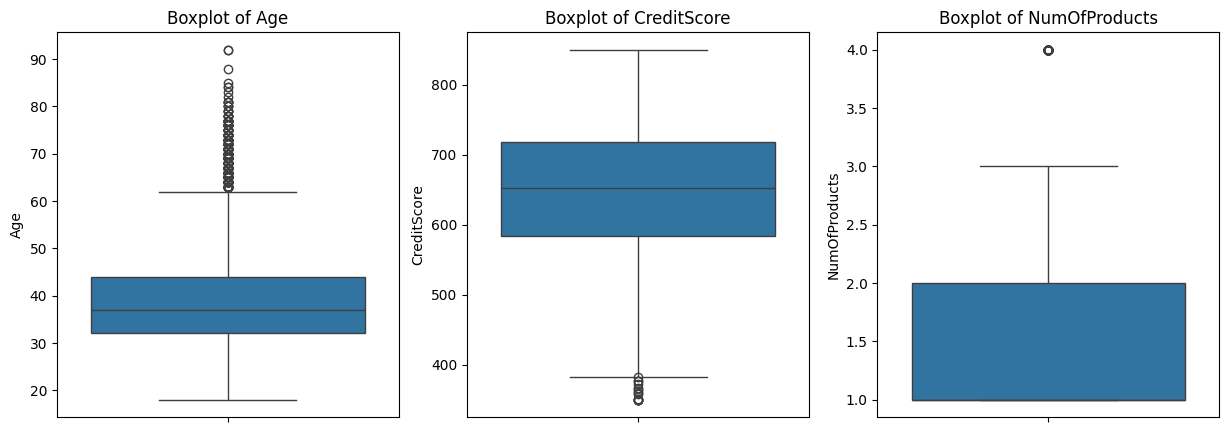

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb

pdf = df.toPandas()

plt.figure(figsize=(15,5))

i = 1

for c in ["Age", "CreditScore", "NumOfProducts"]:
    plt.subplot(1, 3, i)
    sb.boxplot(y=c, data=pdf)
    plt.title("Boxplot of " + c)

    i += 1

plt.show()


La caractéristique NumOfProducts contient quatre valeurs discrètes, donc on la conserve, tandis qu'on traite les caractéristiques Age et CreditScore.

On ajuste les bornes minimale et maximale en fonction de la colonne concernée.

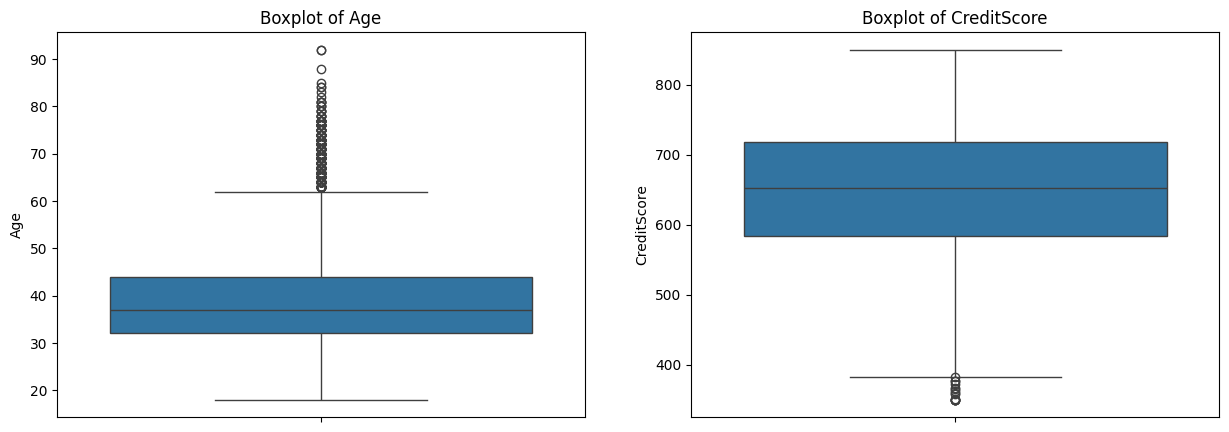

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sb.boxplot(y="Age", data=pdf)
plt.title("Boxplot of Age")

plt.subplot(1, 2, 2)
sb.boxplot(y="CreditScore", data=pdf)
plt.title("Boxplot of CreditScore")

plt.show()


Application d’une transformation logarithmique sur Age, dont la distribution est asymétrique à droite.

In [7]:
import numpy as np

pdf_copy = pdf.copy()

pdf_copy['Age'] = np.log(pdf_copy['Age'])

Visualisation

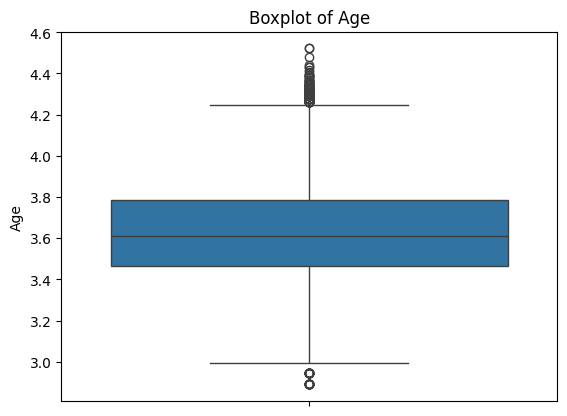

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb


sb.boxplot(y="Age", data=pdf_copy)
plt.title("Boxplot of Age")

plt.show()

La transformation logarithmique n’ayant pas été efficace, une winsorisation de la borne supérieure (3,6 %) a été appliquée afin de corriger l’asymétrie à droite de la caractéristique Age.

In [9]:
from scipy.stats.mstats import winsorize

pdf_copy = pdf.copy()

pdf_copy['Age'] = winsorize(pdf_copy['Age'], limits=[0, 0.036])

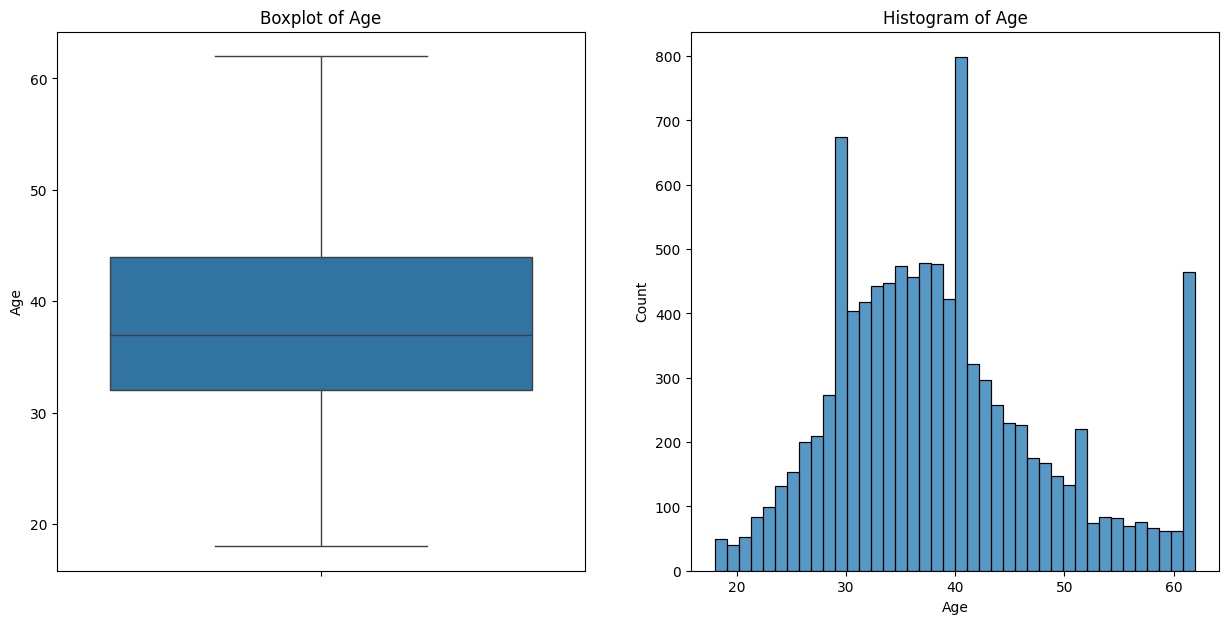

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sb.boxplot(y="Age", data=pdf_copy)
plt.title("Boxplot of Age")

plt.subplot(1, 2, 2)
sb.histplot(pdf_copy["Age"])
plt.title("Histogram of Age")

plt.show()

Sauvegarder les changements

In [11]:
pdf['Age'] = pdf_copy['Age']

Application d’une winsorisation à 0,2 % sur la borne inférieure de la caractéristique CreditScore afin de réduire l’effet des valeurs aberrantes.

In [12]:
from scipy.stats.mstats import winsorize

pdf["CreditScore"] = winsorize(pdf["CreditScore"], limits=[0.002, 0])

Resultats aprés traitement

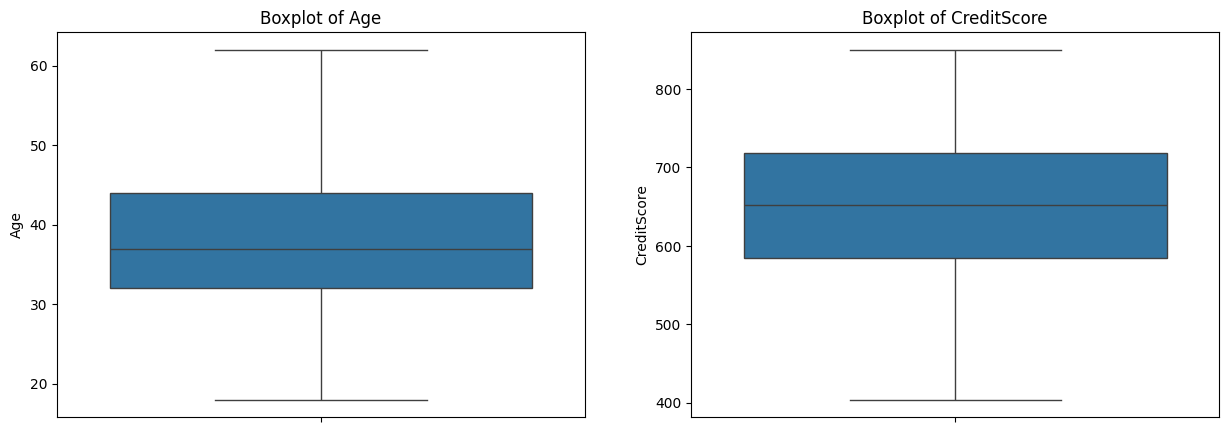

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sb.boxplot(y="Age", data=pdf)
plt.title("Boxplot of Age")

plt.subplot(1, 2, 2)
sb.boxplot(y="CreditScore", data=pdf)
plt.title("Boxplot of CreditScore")

plt.show()


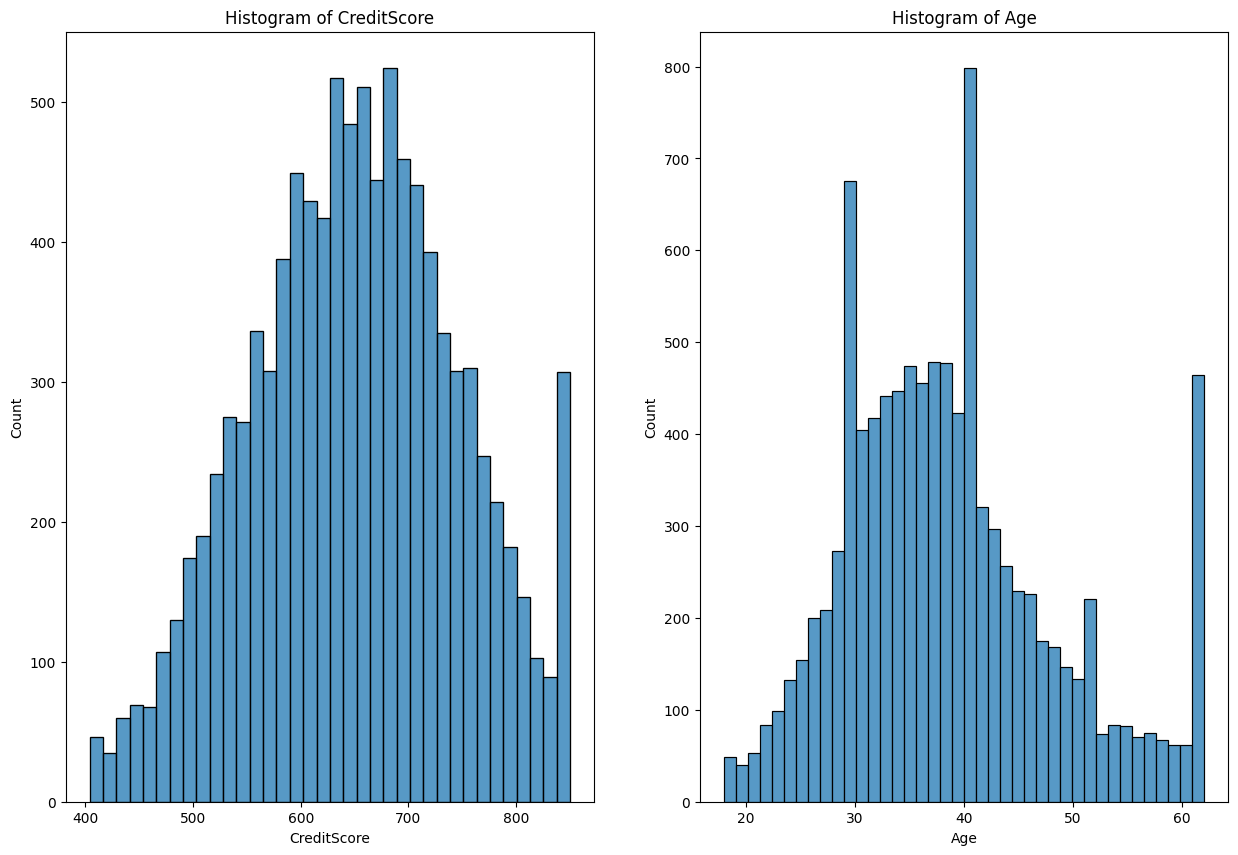

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
sb.histplot(pdf["CreditScore"])
plt.title("Histogram of CreditScore")

plt.subplot(1, 2, 2)
sb.histplot(pdf["Age"])
plt.title("Histogram of Age")

plt.show()


Sauvegarder le fichier CSV

In [15]:
pdf.to_csv("../data/processed/data-processed.csv", index=False)

### StringIndexer

In [17]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCol="Geography",
    outputCol="Geography_index"
)

df_indexed = indexer.fit(df).transform(df)

indexer = StringIndexer(
    inputCol="Gender",
    outputCol="Gender_index"
)

df_indexed = indexer.fit(df_indexed).transform(df_indexed)

### OneHotEncoder

In [21]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=["Geography_index"],
    outputCols=["Geography_vec"]
)

df_encoded = encoder.fit(df_indexed).transform(df_indexed)

encoder = OneHotEncoder(
    inputCols=["Gender_index"],
    outputCols=["Gender_vec"]
)

df_encoded = encoder.fit(df_encoded).transform(df_encoded)

### Save Dataframe

In [22]:
pdf_encoded = df_encoded.toPandas()

pdf_encoded.to_csv('../data/processed/data-encoded.csv', index=False)